## Dependencies

In [3]:
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

vader = SentimentIntensityAnalyzer()

/home/miellilas/Documents/pba/myanimelist/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataset

In [2]:
df = pd.read_csv(r"../data/processed/top_150_fantasy_reviews_cleaned_balanced.csv")
df.head()

,review_id,anime_title,review_url,date,username,user_review_count,is_preliminary,episodes_watched,recommendation,rating,...,total_reactions,nice_count,love_it_count,funny_count,confusing_count,informative_count,well_written_count,creative_count,review_sentiment,review_nerpos
0,503754,Sousou no Frieren,https://myanimelist.net/reviews.php?id=503754,"Oct 13, 2023 8:38 AM",Czekaj,5,True,5/28,Recommended,10,...,1352,282,837,44,58,5,124,2,with lives so short why do we even bother? to ...,"With lives so short, why do we even bother? To..."
1,519189,Sousou no Frieren,https://myanimelist.net/reviews.php?id=519189,"Mar 22, 2024 12:40 PM",chekkit,25,False,NaN,Recommended,10,...,1223,252,794,43,52,8,70,4,i feel so catered to it feels like an eternity...,I feel so catered to. It feels like an eternit...
2,506314,Sousou no Frieren,https://myanimelist.net/reviews.php?id=506314,"Nov 10, 2023 3:29 PM",Hallideus,3,True,10/28,Recommended,10,...,222,71,107,23,13,0,8,0,i feel some of the other reviews say it all to...,I feel some of the other reviews say it all to...
3,506301,Sousou no Frieren,https://myanimelist.net/reviews.php?id=506301,"Nov 10, 2023 9:52 AM",Gamer651,9,True,10/28,Recommended,10,...,183,43,88,29,15,0,7,1,it is been 3 years since i last wrote up a rev...,It is been 3 years since I last wrote up a rev...
4,507559,Sousou no Frieren,https://myanimelist.net/reviews.php?id=507559,"Nov 25, 2023 3:17 PM",alexspace38,2,True,12/28,Recommended,10,...,157,30,79,34,11,0,3,0,first time i felt compelled to write a review ...,First time I felt compelled to write a review ...


In [29]:
df_old = pd.read_csv(r"../data/processed/top_150_fantasy_reviews_cleaned.csv")
df_old.head()

,review_id,anime_title,review_url,date,username,user_review_count,is_preliminary,episodes_watched,recommendation,rating,...,total_reactions,nice_count,love_it_count,funny_count,confusing_count,informative_count,well_written_count,creative_count,review_sentiment,review_nerpos
0,503754,Sousou no Frieren,https://myanimelist.net/reviews.php?id=503754,"Oct 13, 2023 8:38 AM",Czekaj,5,True,5/28,Recommended,10,...,1347,281,833,44,58,5,124,2,with lives so short why do we even bother? to...,"With lives so short, why do we even bother? To..."
1,519189,Sousou no Frieren,https://myanimelist.net/reviews.php?id=519189,"Mar 22, 2024 12:40 PM",chekkit,25,False,NaN,Recommended,10,...,1211,248,789,43,50,8,70,3,i feel so catered to it feels like an eternit...,I feel so catered to. It feels like an eternit...
2,519472,Sousou no Frieren,https://myanimelist.net/reviews.php?id=519472,"Mar 24, 2024 2:03 AM",Trikkiez,3,False,NaN,Not Recommended,4,...,4219,630,105,1966,1355,29,123,11,style frieren does not have its own unique st...,Style- Frieren does not have its own unique st...
3,512466,Sousou no Frieren,https://myanimelist.net/reviews.php?id=512466,"Jan 12, 2024 11:25 AM",ShabbaRico,12,True,18/28,Not Recommended,5,...,931,183,28,400,267,9,42,2,tl dr 5 10 i do not recommend this for anyon...,"TL;DR: 5/10, I do not recommend this for anyon..."
4,503760,Sousou no Frieren,https://myanimelist.net/reviews.php?id=503760,"Oct 13, 2023 9:10 AM",TheRealist68,16,True,6/28,Mixed Feelings,9,...,953,412,60,31,314,10,122,4,through 3 episodes frieren appears to be a un...,"Through 3 episodes, Frieren appears to be a un..."


#### Comparison Between Balanced and Old Dataset

In [31]:
df["recommendation"].value_counts()

recommendation
Recommended        2319
Mixed Feelings     1405
Not Recommended    1136
Name: count, dtype: int64

In [30]:
df_old["recommendation"].value_counts()

recommendation
Recommended        1704
Not Recommended     378
Mixed Feelings      321
Name: count, dtype: int64

## TextBlob Sentiment Analysis

In [4]:
def get_textblob_sentiment(text):
    blob = TextBlob(text)
    return pd.Series({
        "textblob_polarity": blob.sentiment.polarity,
        "textblob_subjectivity": blob.sentiment.subjectivity
    })

df[['textblob_polarity', 'textblob_subjectivity']] = df['review_sentiment'].apply(get_textblob_sentiment)

In [5]:
def label_polarity(p):
    if p > 0.1:
        return 'positive'
    elif p < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['textblob_label'] = df['textblob_polarity'].apply(label_polarity)

In [6]:
df.head()

,review_id,anime_title,review_url,date,username,user_review_count,is_preliminary,episodes_watched,recommendation,rating,...,funny_count,confusing_count,informative_count,well_written_count,creative_count,review_sentiment,review_nerpos,textblob_polarity,textblob_subjectivity,textblob_label
0,503754,Sousou no Frieren,https://myanimelist.net/reviews.php?id=503754,"Oct 13, 2023 8:38 AM",Czekaj,5,True,5/28,Recommended,10,...,44,58,5,124,2,with lives so short why do we even bother? to ...,"With lives so short, why do we even bother? To...",0.087698,0.506092,neutral
1,519189,Sousou no Frieren,https://myanimelist.net/reviews.php?id=519189,"Mar 22, 2024 12:40 PM",chekkit,25,False,NaN,Recommended,10,...,43,52,8,70,4,i feel so catered to it feels like an eternity...,I feel so catered to. It feels like an eternit...,0.188848,0.523496,positive
2,506314,Sousou no Frieren,https://myanimelist.net/reviews.php?id=506314,"Nov 10, 2023 3:29 PM",Hallideus,3,True,10/28,Recommended,10,...,23,13,0,8,0,i feel some of the other reviews say it all to...,I feel some of the other reviews say it all to...,0.194363,0.460784,positive
3,506301,Sousou no Frieren,https://myanimelist.net/reviews.php?id=506301,"Nov 10, 2023 9:52 AM",Gamer651,9,True,10/28,Recommended,10,...,29,15,0,7,1,it is been 3 years since i last wrote up a rev...,It is been 3 years since I last wrote up a rev...,0.198834,0.496649,positive
4,507559,Sousou no Frieren,https://myanimelist.net/reviews.php?id=507559,"Nov 25, 2023 3:17 PM",alexspace38,2,True,12/28,Recommended,10,...,34,11,0,3,0,first time i felt compelled to write a review ...,First time I felt compelled to write a review ...,0.479167,0.745238,positive


## Vader Sentiment Analysis

In [7]:
def get_vader_sentiment(text):
    scores = vader.polarity_scores(text)
    return pd.Series({
        'vader_neg': scores['neg'],
        'vader_neu': scores['neu'],
        'vader_pos': scores['pos'],
        'vader_compound': scores['compound']
    })

df[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']] = df['review_sentiment'].apply(get_vader_sentiment)

In [8]:
def label_vader(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_label'] = df['vader_compound'].apply(label_vader)

In [9]:
df.head()

,review_id,anime_title,review_url,date,username,user_review_count,is_preliminary,episodes_watched,recommendation,rating,...,review_sentiment,review_nerpos,textblob_polarity,textblob_subjectivity,textblob_label,vader_neg,vader_neu,vader_pos,vader_compound,vader_label
0,503754,Sousou no Frieren,https://myanimelist.net/reviews.php?id=503754,"Oct 13, 2023 8:38 AM",Czekaj,5,True,5/28,Recommended,10,...,with lives so short why do we even bother? to ...,"With lives so short, why do we even bother? To...",0.087698,0.506092,neutral,0.068,0.853,0.079,0.8890,positive
1,519189,Sousou no Frieren,https://myanimelist.net/reviews.php?id=519189,"Mar 22, 2024 12:40 PM",chekkit,25,False,NaN,Recommended,10,...,i feel so catered to it feels like an eternity...,I feel so catered to. It feels like an eternit...,0.188848,0.523496,positive,0.051,0.757,0.192,0.9987,positive
2,506314,Sousou no Frieren,https://myanimelist.net/reviews.php?id=506314,"Nov 10, 2023 3:29 PM",Hallideus,3,True,10/28,Recommended,10,...,i feel some of the other reviews say it all to...,I feel some of the other reviews say it all to...,0.194363,0.460784,positive,0.011,0.846,0.143,0.9936,positive
3,506301,Sousou no Frieren,https://myanimelist.net/reviews.php?id=506301,"Nov 10, 2023 9:52 AM",Gamer651,9,True,10/28,Recommended,10,...,it is been 3 years since i last wrote up a rev...,It is been 3 years since I last wrote up a rev...,0.198834,0.496649,positive,0.041,0.801,0.157,0.9909,positive
4,507559,Sousou no Frieren,https://myanimelist.net/reviews.php?id=507559,"Nov 25, 2023 3:17 PM",alexspace38,2,True,12/28,Recommended,10,...,first time i felt compelled to write a review ...,First time I felt compelled to write a review ...,0.479167,0.745238,positive,0.000,0.722,0.278,0.9895,positive


## BERT Sentiment Analysis

In [13]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    truncation=True
)

def map_star_to_label(star):
    if star <= 2:
        return "negative"
    elif star == 3:
        return "neutral"
    else:
        return "positive"

def get_sentiment(text):
    result = sentiment_pipeline(text)[0]
    stars = int(result['label'].split()[0])  # e.g. '4 stars' → 4
    return pd.Series({
        "bert_label": map_star_to_label(stars),
        "bert_score": result['score']
    })

df[['bert_label', 'bert_score']] = df['review_sentiment'].apply(get_sentiment)

Device set to use cuda:0


In [14]:
df.head()

,review_id,anime_title,review_url,date,username,user_review_count,is_preliminary,episodes_watched,recommendation,rating,...,textblob_polarity,textblob_subjectivity,textblob_label,vader_neg,vader_neu,vader_pos,vader_compound,vader_label,bert_label,bert_score
0,503754,Sousou no Frieren,https://myanimelist.net/reviews.php?id=503754,"Oct 13, 2023 8:38 AM",Czekaj,5,True,5/28,Recommended,10,...,0.087698,0.506092,neutral,0.068,0.853,0.079,0.8890,positive,negative,0.336350
1,519189,Sousou no Frieren,https://myanimelist.net/reviews.php?id=519189,"Mar 22, 2024 12:40 PM",chekkit,25,False,NaN,Recommended,10,...,0.188848,0.523496,positive,0.051,0.757,0.192,0.9987,positive,positive,0.462899
2,506314,Sousou no Frieren,https://myanimelist.net/reviews.php?id=506314,"Nov 10, 2023 3:29 PM",Hallideus,3,True,10/28,Recommended,10,...,0.194363,0.460784,positive,0.011,0.846,0.143,0.9936,positive,positive,0.551359
3,506301,Sousou no Frieren,https://myanimelist.net/reviews.php?id=506301,"Nov 10, 2023 9:52 AM",Gamer651,9,True,10/28,Recommended,10,...,0.198834,0.496649,positive,0.041,0.801,0.157,0.9909,positive,positive,0.538418
4,507559,Sousou no Frieren,https://myanimelist.net/reviews.php?id=507559,"Nov 25, 2023 3:17 PM",alexspace38,2,True,12/28,Recommended,10,...,0.479167,0.745238,positive,0.000,0.722,0.278,0.9895,positive,positive,0.868465


### Save Cleaned Dataset

In [15]:
df.to_csv(r'../data/processed/top_150_fantasy_reviews_sentiment_balanced.csv', index=False)

## TextBlob Visualization

#### Jumlah Review per Label Sentimen TextBlob

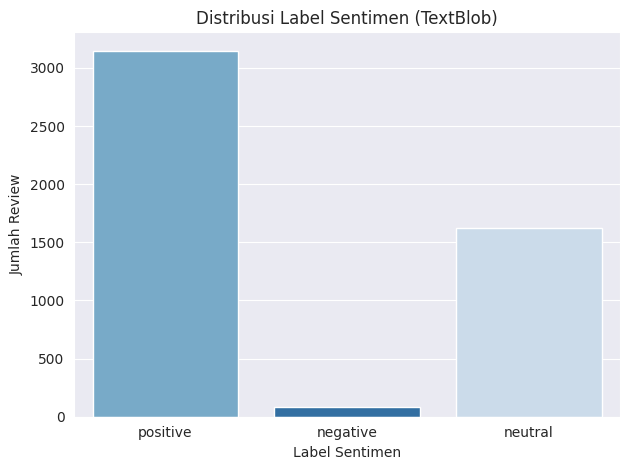

In [16]:
sns.countplot(data=df, x='textblob_label', order=['positive', 'negative', 'neutral'], palette='Blues', hue='textblob_label')
plt.title('Distribusi Label Sentimen (TextBlob)')
plt.xlabel('Label Sentimen')
plt.ylabel('Jumlah Review')
plt.tight_layout()
plt.show()

#### Perbandingan Distribusi Nilai Polaritas TextBlob

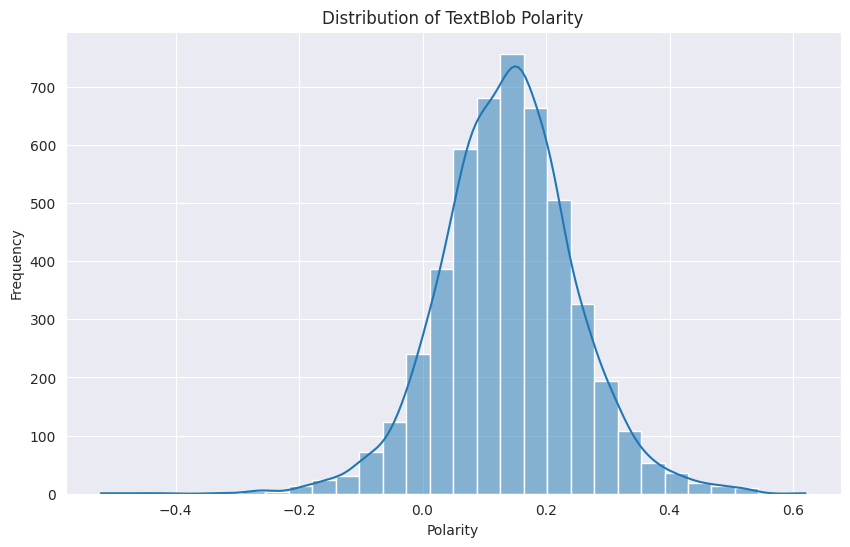

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df['textblob_polarity'], bins=30, kde=True)
plt.title('Distribution of TextBlob Polarity')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Perbandingan Hasil TextBlob dengan Rekomendasi Actual

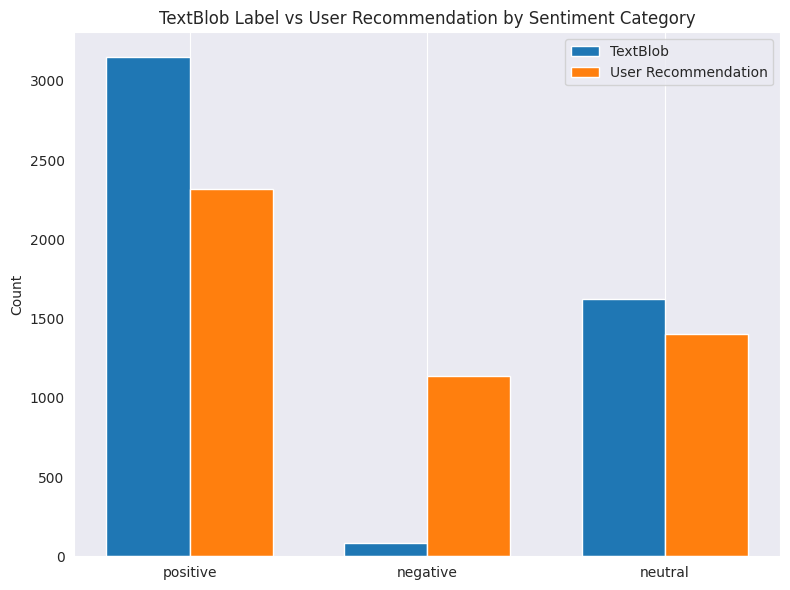

recommendation
Recommended        2319
Mixed Feelings     1405
Not Recommended    1136
Name: count, dtype: int64


In [18]:
categories = ['positive', 'negative', 'neutral']
matched_recommendations = ['Recommended', 'Not Recommended', 'Mixed Feelings']

textblob_counts = [df[df['textblob_label'] == cat].shape[0] for cat in categories]
recommendation_counts = [
    df[df['recommendation'] == rec].shape[0] for rec in matched_recommendations
]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, textblob_counts, width, label='TextBlob')
bars2 = ax.bar(x + width/2, recommendation_counts, width, label='User Recommendation')

# Formatting
ax.set_ylabel('Count')
ax.set_title('TextBlob Label vs User Recommendation by Sentiment Category')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(axis='y')

plt.tight_layout()
plt.show()

print(df["recommendation"].value_counts())

## Vader Visualization

#### Jumlah Review per Label Sentimen Vader


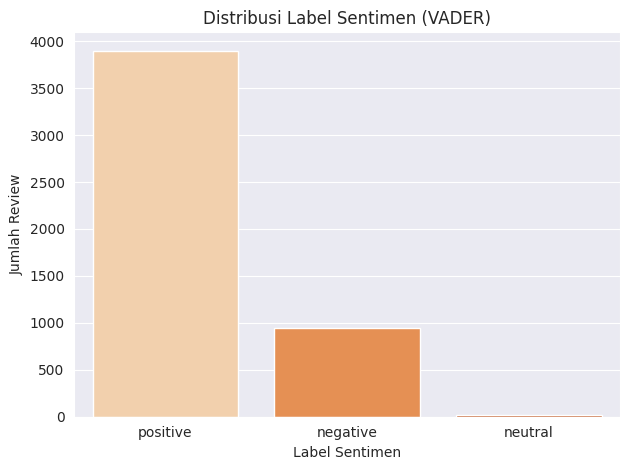

In [19]:
sns.countplot(data=df, x='vader_label', order=['positive', 'negative', 'neutral'], palette='Oranges', hue='vader_label')
plt.title('Distribusi Label Sentimen (VADER)')
plt.xlabel('Label Sentimen')
plt.ylabel('Jumlah Review')
plt.tight_layout()
plt.show()

#### Perbandingan Distribusi Nilai Compound VADER

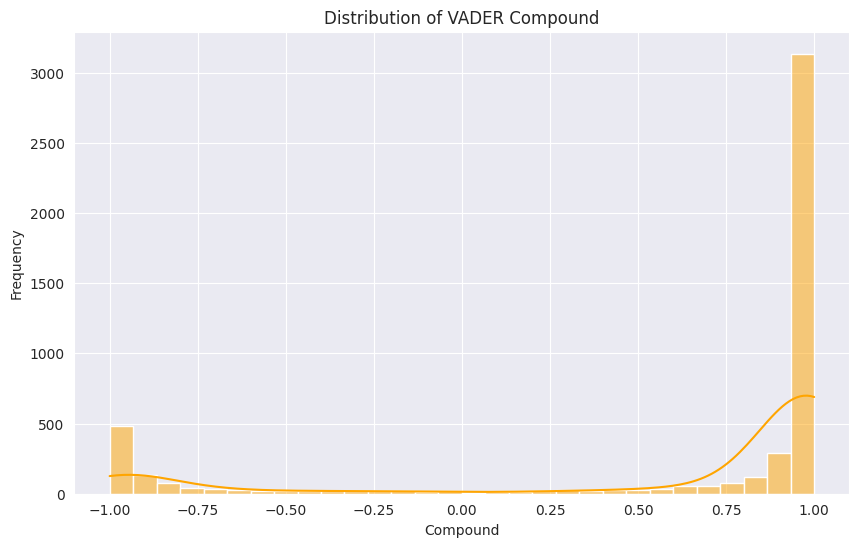

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(df['vader_compound'], bins=30, kde=True, color='orange')
plt.title('Distribution of VADER Compound')
plt.xlabel('Compound')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Perbandingan Hasil VADER dengan Rekomendasi Actual

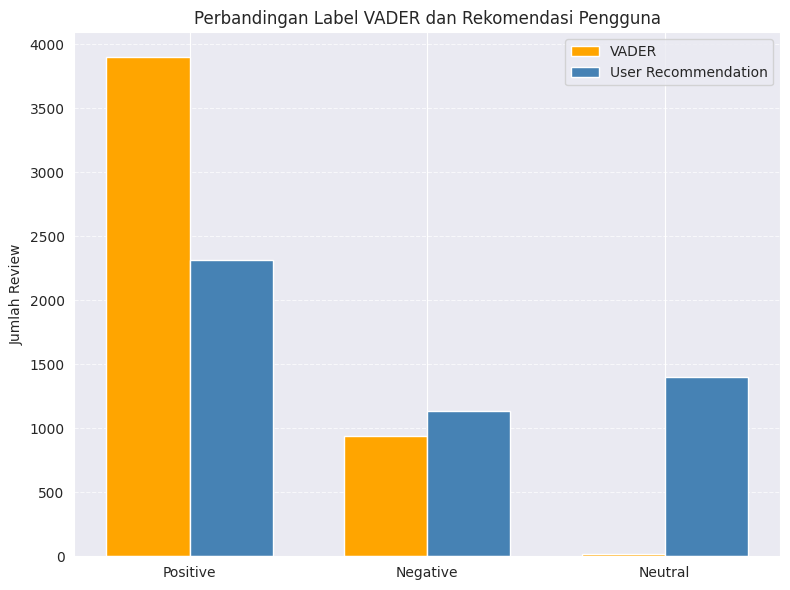

In [21]:
categories = ['positive', 'negative', 'neutral']
matched_recommendations = ['Recommended', 'Not Recommended', 'Mixed Feelings']

vader_counts = [df[df['vader_label'] == cat].shape[0] for cat in categories]
recommendation_counts = [
    df[df['recommendation'] == rec].shape[0] for rec in matched_recommendations
]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

bars1 = ax.bar(x - width/2, vader_counts, width, label='VADER', color='#FFA500')  # Orange
bars2 = ax.bar(x + width/2, recommendation_counts, width, label='User Recommendation', color='#4682B4')  # Steel Blue

ax.set_ylabel('Jumlah Review')
ax.set_title('Perbandingan Label VADER dan Rekomendasi Pengguna')
ax.set_xticks(x)
ax.set_xticklabels(['Positive', 'Negative', 'Neutral'])
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## BERT Visualization

#### Jumlah Review per Label Sentimen BERT


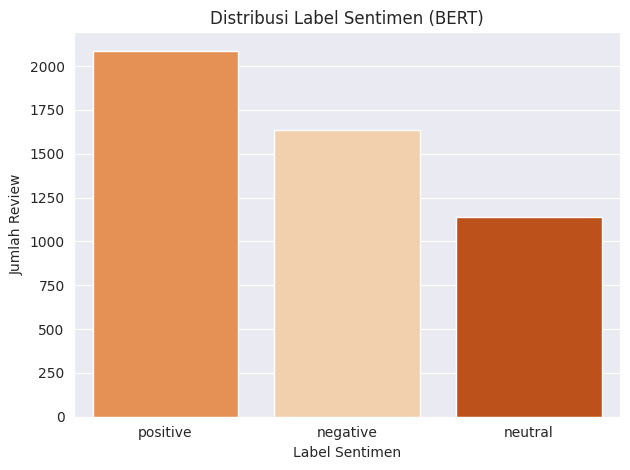

In [23]:
sns.countplot(data=df, x='bert_label', order=['positive', 'negative', 'neutral'], palette='Oranges', hue='bert_label')
plt.title('Distribusi Label Sentimen (BERT)')
plt.xlabel('Label Sentimen')
plt.ylabel('Jumlah Review')
plt.tight_layout()
plt.show()

#### Perbandingan Distribusi Nilai Compound VADER

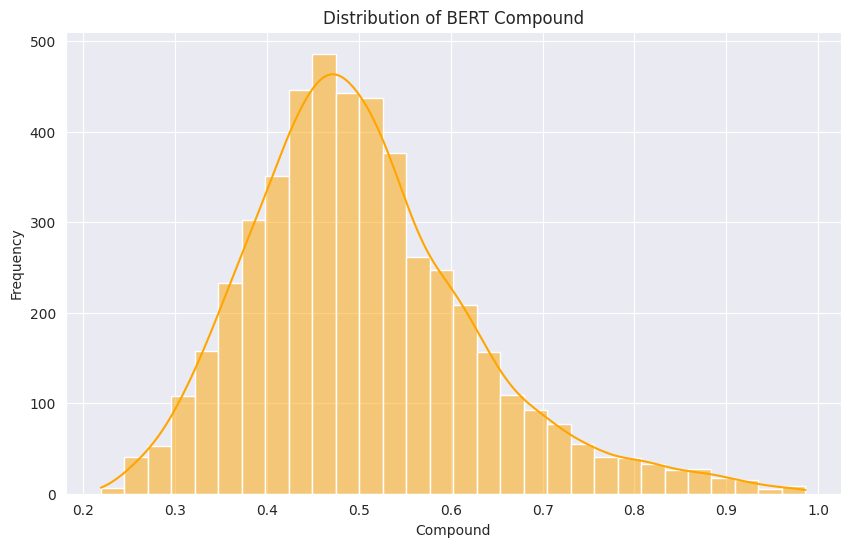

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(df['bert_score'], bins=30, kde=True, color='orange')
plt.title('Distribution of BERT Compound')
plt.xlabel('Compound')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Perbandingan Hasil VADER dengan Rekomendasi Actual

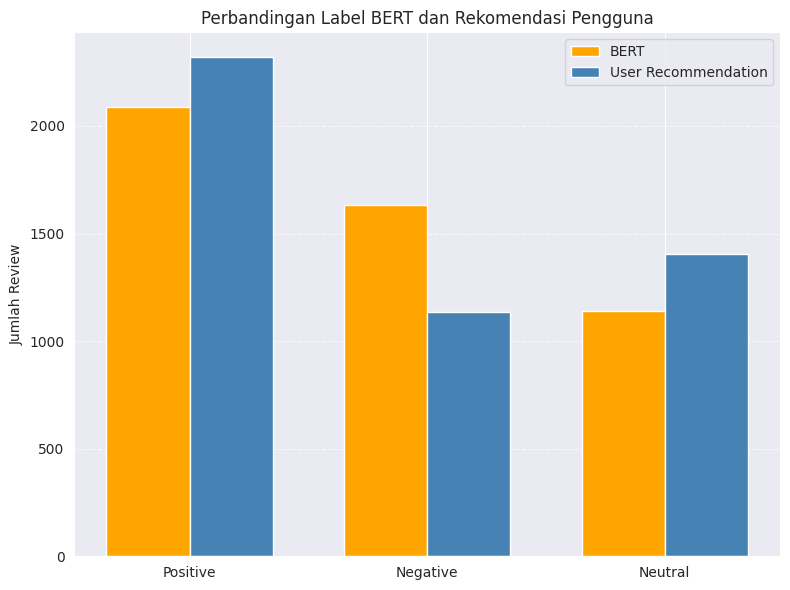

In [26]:
categories = ['positive', 'negative', 'neutral']
matched_recommendations = ['Recommended', 'Not Recommended', 'Mixed Feelings']

vader_counts = [df[df['bert_label'] == cat].shape[0] for cat in categories]
recommendation_counts = [
    df[df['recommendation'] == rec].shape[0] for rec in matched_recommendations
]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

bars1 = ax.bar(x - width/2, vader_counts, width, label='BERT', color='#FFA500')  # Orange
bars2 = ax.bar(x + width/2, recommendation_counts, width, label='User Recommendation', color='#4682B4')  # Steel Blue

ax.set_ylabel('Jumlah Review')
ax.set_title('Perbandingan Label BERT dan Rekomendasi Pengguna')
ax.set_xticks(x)
ax.set_xticklabels(['Positive', 'Negative', 'Neutral'])
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## TextBlob vs VADER Results

#### Classification Report F1

In [27]:
def map_recommendation(rec):
    if rec == 'Recommended':
        return 'positive'
    elif rec == 'Not Recommended':
        return 'negative'
    else:
        return 'neutral'

df['recommendation_mapped'] = df['recommendation'].apply(map_recommendation)

print("=== Evaluation for TextBlob ===")
print(classification_report(df['recommendation_mapped'], df['textblob_label'], digits=3))

print("=== Evaluation for VADER ===")
print(classification_report(df['recommendation_mapped'], df['vader_label'], digits=3))

print("=== Evaluation for BERT ===")
print(classification_report(df['recommendation_mapped'], df['bert_label'], digits=3))

=== Evaluation for TextBlob ===
              precision    recall  f1-score   support

    negative      0.744     0.056     0.105      1136
     neutral      0.367     0.425     0.394      1405
    positive      0.654     0.888     0.753      2319

    accuracy                          0.560      4860
   macro avg      0.588     0.456     0.417      4860
weighted avg      0.592     0.560     0.498      4860

=== Evaluation for VADER ===
              precision    recall  f1-score   support

    negative      0.561     0.466     0.509      1136
     neutral      0.412     0.005     0.010      1405
    positive      0.568     0.956     0.713      2319

    accuracy                          0.566      4860
   macro avg      0.514     0.475     0.410      4860
weighted avg      0.521     0.566     0.462      4860

=== Evaluation for BERT ===
              precision    recall  f1-score   support

    negative      0.555     0.798     0.655      1136
     neutral      0.516     0.418     0.

#### Confusion Matrix Visualization

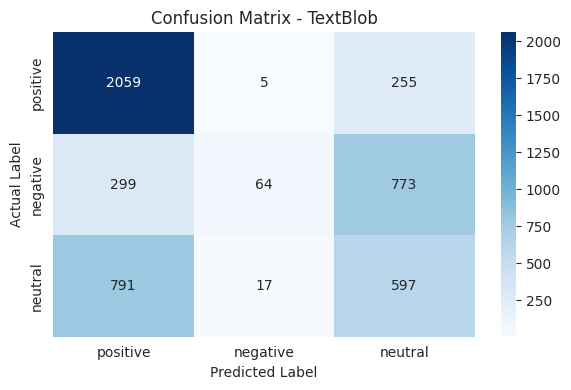

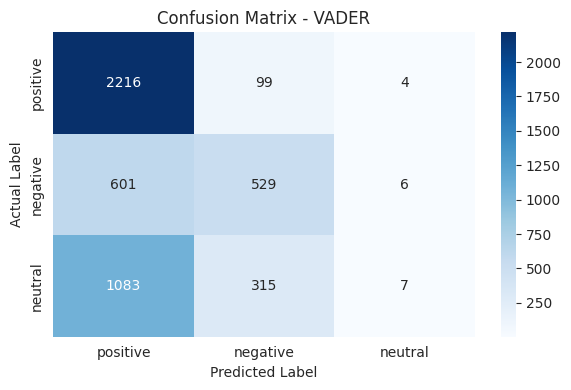

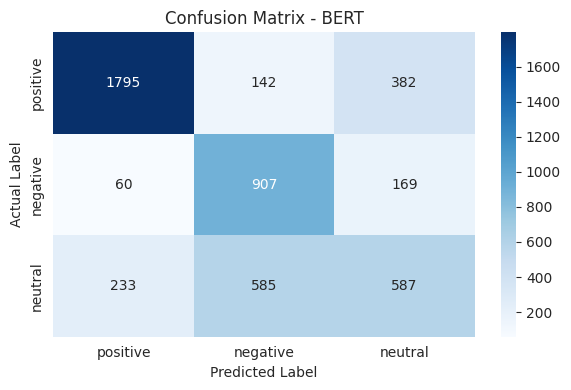

In [28]:
label_map = {
    'Recommended': 'positive',
    'Not Recommended': 'negative',
    'Mixed Feelings': 'neutral'
}

df['recommendation_sentiment'] = df['recommendation'].map(label_map)

cm_textblob = confusion_matrix(df['recommendation_sentiment'], df['textblob_label'], labels=['positive', 'negative', 'neutral'])
cm_vader = confusion_matrix(df['recommendation_sentiment'], df['vader_label'], labels=['positive', 'negative', 'neutral'])
cm_bert = confusion_matrix(df['recommendation_sentiment'], df['bert_label'], labels=['positive', 'negative', 'neutral'])

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['positive', 'negative', 'neutral'],
                yticklabels=['positive', 'negative', 'neutral'])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm_textblob, "Confusion Matrix - TextBlob")
plot_confusion_matrix(cm_vader, "Confusion Matrix - VADER")
plot_confusion_matrix(cm_bert, "Confusion Matrix - BERT")